In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Análisis de una señal armónica

Ua señal armónica es aquella que tiene una única componente de Fourier. Este tipo de señales son teóricas, ya que se requiere que la duración sea infinita, pero se puede aproximar como se ve a continuación

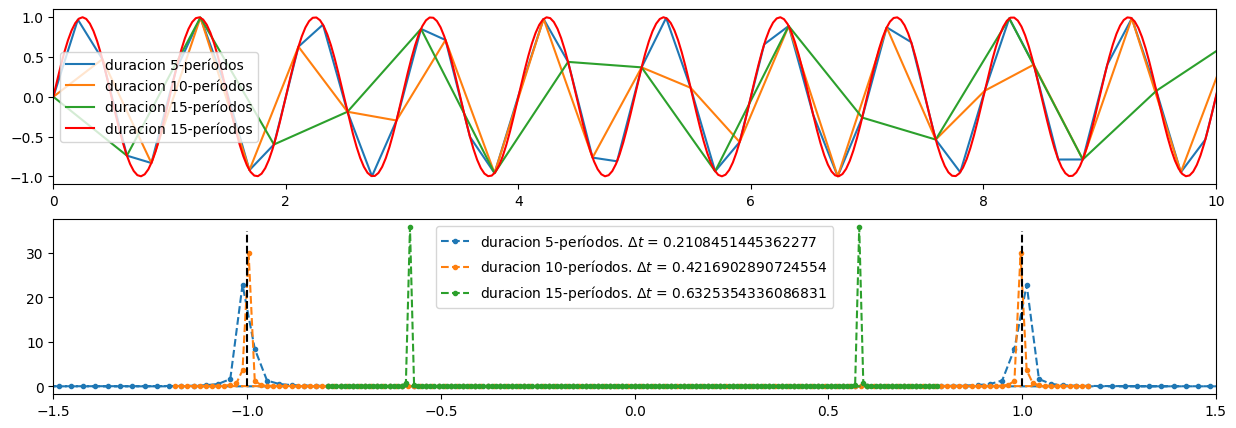

In [2]:
# Vamos a utilizar una cantidad fija de puntos, analizando mayor duración
n = 150 # numero de puntos
f = 1 # frecuencia
fig, axs = plt.subplots(2,1,figsize=(15,5))
for i in range(5,20,5):
    t = np.linspace(0, i * 2 * np.pi,n)    
    x = np.sin(2*np.pi*f*t)
    axs[0].plot(t,x,label=f'duracion {i}-períodos')
    dft = np.fft.fft(x, norm='ortho')
    freqs = np.fft.fftfreq(n,t[1]-t[0])
    axs[1].plot(freqs, np.abs(dft)**2, '--o', ms  =3, label = f'duracion {i}-períodos. $\Delta t$ = {t[1]-t[0]}')
axs[0].set_xlim(0,10)
n = 3000 # numero de puntos
f = 1 # frecuencia
t = np.linspace(0, 15 * 2 * np.pi,n)    
x = np.sin(2*np.pi*f*t)
axs[0].plot(t,x,'r-',label=f'duracion {15}-períodos')
axs[0].legend()
axs[1].vlines([-1,1],0,35, colors='k',linestyles='dashed')
axs[1].set_xlim(-1.5,1.5)
axs[1].legend()
plt.show()

* La función seno se puede escribir como $sin(x) = \frac{exp(ix)-exp(-ix)}{2i}$, por lo que en el caso anterior se encuentran las frecuencias f = {1,-1}. 
* Es importante notar el factor $2\pi$ que acompaña a la frecuencia. 
* La frecuencia máxima posible estará determinada por $\Delta t$ y el número total de puntos
* No siempre se puede encontrar la frecuencia exacta de la serie temporal, esta debe coincidir con la discretización temporal y de frecuencia. La razón de la falta de posibilidad de representar algunas frecuencias está dada por la denominada frecuencia de **Nyquist**, el caso de 15 períodos con pocos puntos, donde la frecuencia que se observa es ficticia y está dada sólo por un efecto de discretización.

## Estimación de la estacionalidad de una ST

El siguiente ejemplo es de los valores del acelerómetro de un teléfono móvil al caminar. 

Es importante recordar que por los factores $2 \pi$ de la definición del algoritmo FFT, el período de oscilación se obtiene como
$$
\tau = \frac{1}{f}
$$


In [3]:
import csv

# datos del acelerometro del telefono movil al caminar
with open('../../Data/acelerometro/caminata-ejemplo.csv', 'r') as fp:
    reader = csv.reader(fp, delimiter=';')
    col_names = next(reader)
    data = []
    for row in reader:
        data.append([float(r) for r in row])
data = np.array(data)
time = data[:,0]
signal_x = data[:,1]
print(time[:10])

[0.00236734 0.00305818 0.00344318 0.00396255 0.00505089 0.00530917
 0.00553057 0.01163896 0.01210511 0.01234198]


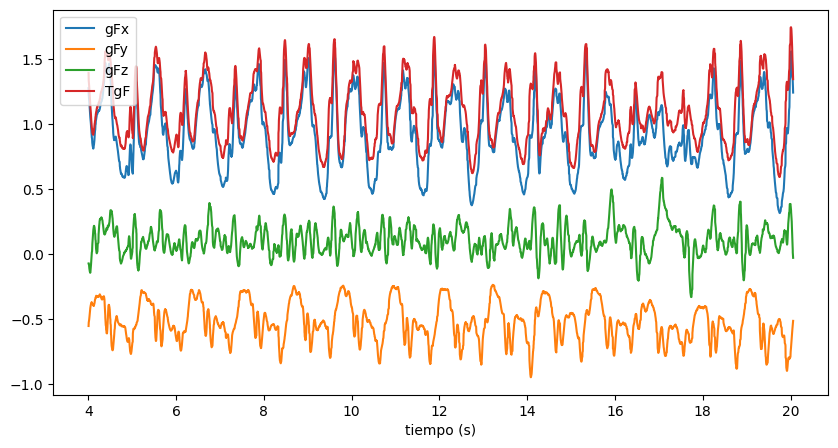

In [4]:
plt.figure(figsize=(10,5))
plt.xlabel('tiempo (s)')
for i in range(len(col_names)-1):
    plt.plot(data[2000:10000,0],data[2000:10000,i+1], label=col_names[i+1])
plt.legend()

Para hacer un análisis mediante la FFT, primero hay que tener intervalos de tiempo regulares, el sampleo debe realizarse con frecuencia constante. En este ejemplo puede verse que no es el caso. Si bien existen técnicas de estimación, en este ejemplo tomaremos una estrategia simple: vamos a hacer un resampleo de la serie temporal mediante interpolaciones para obtener los valores de la serie en intervalos regulares.

Primero veamos el sampleo de la grilla temporal

min dt: 0.00015567700000218565 - max dt: 0.02275745000000029


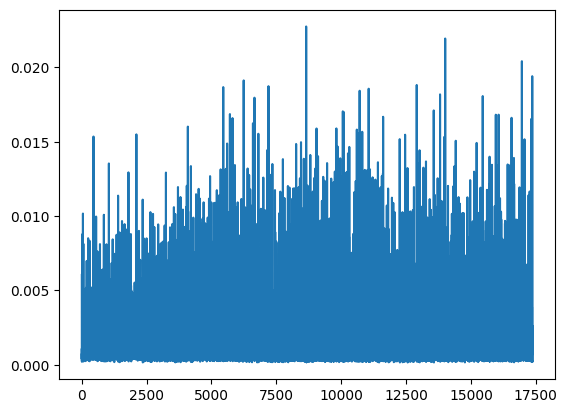

In [5]:
dt = time[1:]-time[:-1]
print(f'min dt: {dt.min()} - max dt: {dt.max()}')
plt.plot(dt)

Dado que la diferencia entre los espaciados temporales oscilan entre 1.5e-4 s y 2.2e-2 s (2 ordenes de magnitud), tomaremos un valor cercano al maximo, en este caso 2e-2 s

grilla experimental
comienzo: 0.002367344s. final: 34.87031462s. N de puntos: 17381
------------------
grilla resampleada
comienzo: 0.002367344s. final: 34.852367344s. N de puntos: 3486


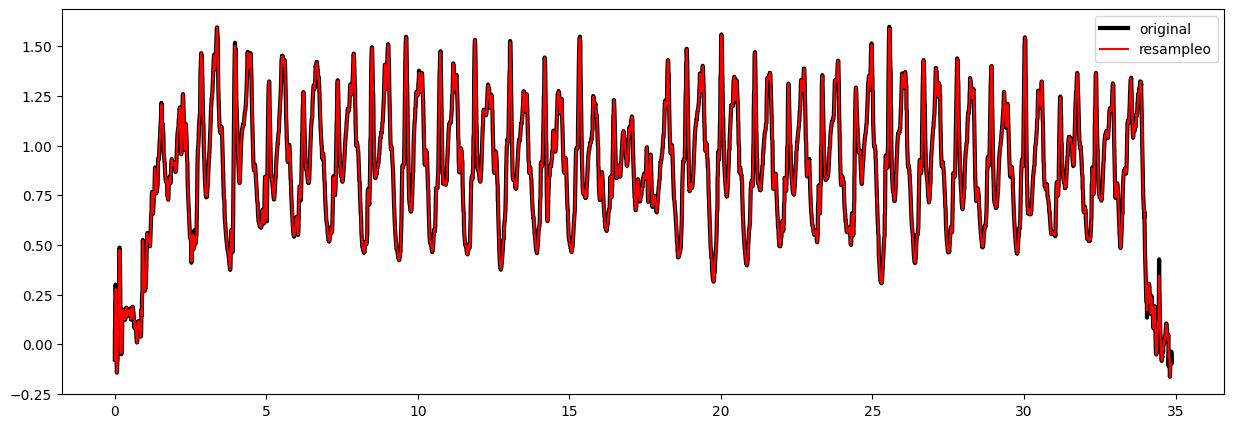

In [6]:
from scipy.interpolate import interp1d
# interpolamos
f = interp1d(time, signal_x, kind = 'linear')
print('grilla experimental')
print(f'comienzo: {time[0]}s. final: {time[-1]}s. N de puntos: {len(time)}')
# necesitamos crear la nueva grilla de tiempo
delta_t = 1e-2 # esta es equiespaciado
n_grid = np.int64((time[-1]-time[0])/delta_t)
new_grid = np.arange(n_grid)*delta_t + time[0]
print('------------------')
print('grilla resampleada')
print(f'comienzo: {new_grid[0]}s. final: {new_grid[-1]}s. N de puntos: {len(new_grid)}')

new_signal_x = f(new_grid)
plt.figure(figsize=(15,5))
plt.plot(time, signal_x, 'k', lw = 3, label = 'original')
plt.plot(new_grid, new_signal_x, 'r', label = 'resampleo')
plt.legend()

Ahora con un sampleo uniforme, se puede hacer el análisis en el dominio de frecuencias. Ya hemos visto que la transformada completa de Fourier tiene las frecuencias positivas y negativas. Dada la simetría, descartaremos las frecuencias negativas

(0.0, 10.0)

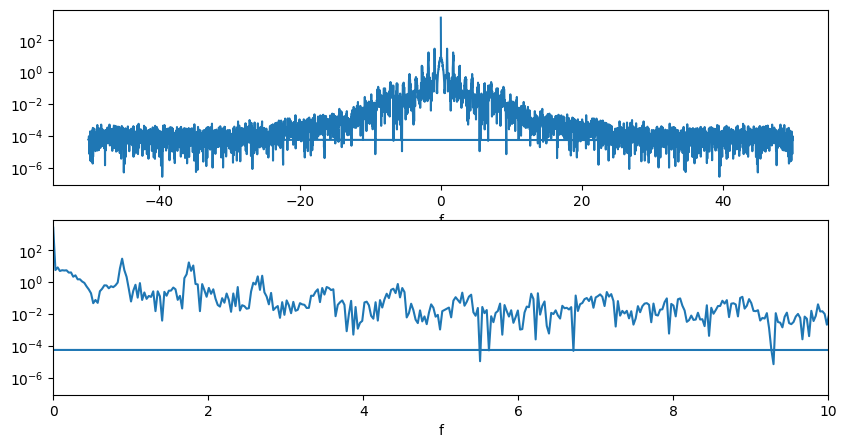

In [7]:
spectral_density = np.abs(np.fft.fft(new_signal_x, axis=0, norm='ortho'))**2
freqs = np.fft.fftfreq(new_grid.shape[0], delta_t)
fig, axs = plt.subplots(2,1,figsize=(10,5))
axs[0].set_xlabel('f')
axs[0].semilogy(freqs,spectral_density)
axs[1].set_xlabel('f')
axs[1].semilogy(freqs,spectral_density)
axs[1].set_xlim(0,10)

A partir del espectro de frecuencias, se puede estimar el ritmo de los pasos.

Encontremos las posiciones de los picos

Períodos de oscilación [ 17.43         1.12451613   0.57147541   0.37085106   0.28809917
   0.22490323   0.18945652   0.15990826   0.14        -0.14
  -0.15990826  -0.18945652  -0.22490323  -0.28809917  -0.37085106
  -0.57147541  -1.12451613 -17.43      ]


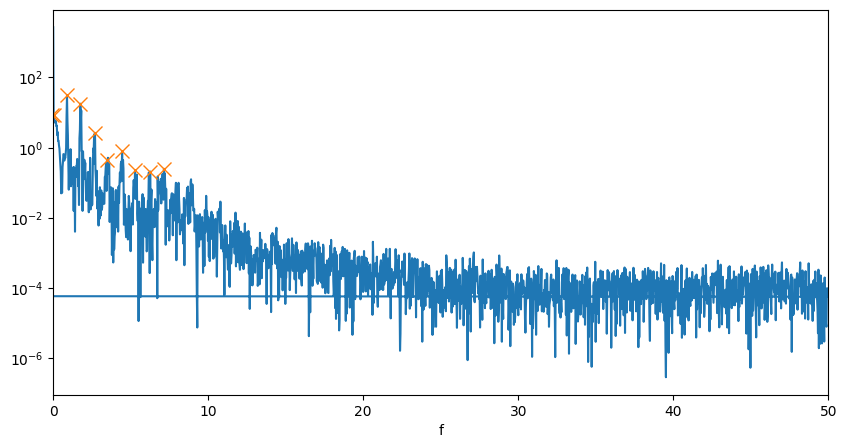

In [12]:
from scipy.signal import find_peaks
peaks = find_peaks(spectral_density,threshold=0.1, distance=20)[0]
print(f'Períodos de oscilación {1/freqs[peaks]}')
plt.figure(figsize=(10,5))
plt.xlabel('f')
plt.semilogy(freqs,spectral_density)
plt.semilogy(freqs[peaks],spectral_density[peaks],'x', ms=10)
plt.xlim(0,50)
plt.show()

In [76]:
from scipy.signal import find_peaks

#suavizamos con un filtro gaussiano la señal

def gauss(x, m, s):
    return np.exp(-(x-m)**2/2/s**2)/np.sqrt(2*np.pi)/s

plantilla = gauss(np.arange(13),6,3)
soft = np.hstack([np.zeros(6),np.convolve(spectral_density[:,0], plantilla, mode='valid'),np.zeros(6)])

Períodos de oscilación [ 2.27902195e+00  5.46965268e-01  3.33515407e-01  1.77586126e-01
  1.47033674e-01  1.19948524e-01  9.56232986e-02  7.95007657e-02
  6.94118360e-02  6.24389575e-02  5.38351642e-02  5.12139764e-02
  4.63529888e-02  4.32725687e-02  3.90689477e-02  3.40152530e-02
  3.12909192e-02  2.90938972e-02  2.71312137e-02  2.55591247e-02
  2.40741755e-02  2.21264267e-02  1.91783053e-02  1.81836858e-02
  1.74637697e-02  1.51766168e-02  1.44394210e-02  1.40825249e-02
  1.38964753e-02  1.34060115e-02  1.29982240e-02  1.15005313e-02
  1.09832383e-02  1.07080123e-02  1.03278940e-02  1.01214890e-02
  9.91597657e-03  9.73941004e-03  9.57572248e-03  8.23742873e-03
  5.95822732e-03  5.12331648e-03  4.88013265e-03  4.44542643e-03
  4.35898365e-03  4.25985411e-03  4.14618911e-03  3.99477993e-03
  3.95778052e-03  3.85947832e-03  3.84104823e-03  3.69671038e-03
  3.59467184e-03  3.56933743e-03  3.55080023e-03  3.53063044e-03
  3.48740926e-03  3.47147289e-03  3.39729980e-03  3.38384848e-03
  

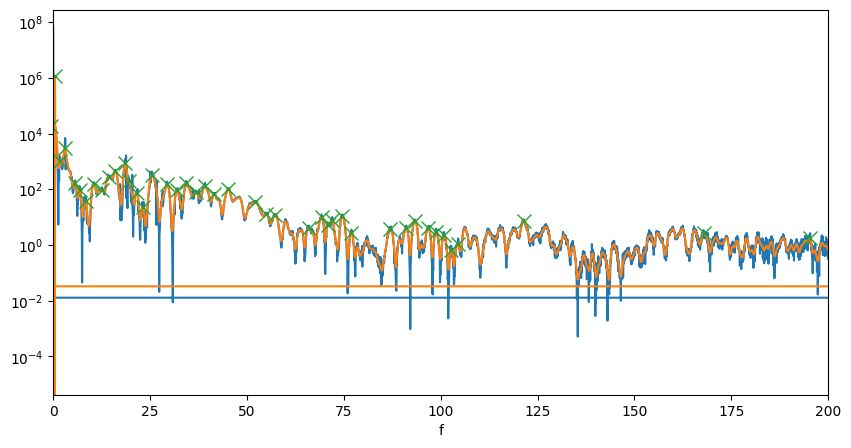

In [77]:
peaks = find_peaks(soft,threshold=0.01, distance=10)[0]
print(f'Períodos de oscilación {1/freqs[peaks]}')
plt.figure(figsize=(10,5))
plt.xlabel('f')
plt.semilogy(freqs,spectral_density[:,0])
plt.semilogy(freqs,soft)
plt.semilogy(freqs[peaks],soft[peaks],'x', ms=10)
plt.xlim(0,200)
plt.show()

In [67]:
1/freqs[peaks]

array([ 0.62062992,  0.19948819,  0.12142759,  0.09630464,  0.07161114,
        0.05319685,  0.04398165,  0.03774101,  0.03364861,  0.03138016,
        0.02821045,  0.0262238 ,  0.02428552,  0.021078  ,  0.01932758,
        0.01784559,  0.01692627,  0.01614355,  0.01501524,  0.01365689,
        0.01281117,  0.01209019,  0.01142264,  0.01088824,  0.01042102,
        0.01006427,  0.00969734,  0.00926313,  0.00888024,  0.00856698,
        0.00829966,  0.00782307,  0.00758922,  0.00737869,  0.00697337,
        0.00679522,  0.00662594,  0.00645742,  0.00631149,  0.00615162,
        0.0060061 ,  0.00587347,  0.00574067,  0.0054923 ,  0.00537084,
        0.00525463,  0.00514334,  0.00504122,  0.00486133,  0.00477   ,
        0.00467811,  0.00459726,  0.00451915,  0.00444365,  0.00437406,
        0.00430329,  0.00423157,  0.0041591 ,  0.00357597,  0.00338731,
        0.00322126, -0.00322126, -0.00338731, -0.00357597, -0.0041591 ,
       -0.00423157, -0.00430329, -0.00437406, -0.00444365, -0.00

In [48]:
soft[peaks]

array([6.42782631e+06, 2.13754813e+05, 5.98981666e+05, 9.07427957e+03,
       6.10266745e+04, 2.69873498e+04, 1.41207793e+04, 5.74553675e+03,
       2.36702073e+03, 1.15429720e+04, 8.92066766e+02, 2.47028579e+03,
       6.48821504e+03, 9.67773841e+02, 1.13179303e+03, 8.99290470e+02,
       1.48496966e+03, 2.97741254e+02, 4.40295796e+02, 2.38203710e+02,
       9.20989640e+01, 7.50149768e+01, 7.15980950e+01, 1.01386565e+02,
       7.65326871e+01, 1.02166384e+02, 6.18639913e+01, 8.84533154e+01,
       6.36511278e+01, 1.07147829e+02, 1.63613880e+01, 2.59058194e+01,
       2.03565442e+01, 4.05134143e+01, 3.44064543e+01, 3.09301685e+01,
       3.25786615e+01, 2.27512404e+01, 1.44821615e+01, 5.81958328e+01,
       5.14387153e+01, 4.08144570e+01, 2.25182075e+01, 1.90619941e+01,
       2.59506082e+01, 9.62043156e+00, 2.41467614e+01, 1.65373280e+01,
       1.05470865e+01, 7.29755482e+00, 1.61105476e+01, 1.83165993e+01,
       1.40714818e+01, 1.85488445e+01, 7.56799768e+00, 1.39907328e+01,
      

(0.0, 10.0)

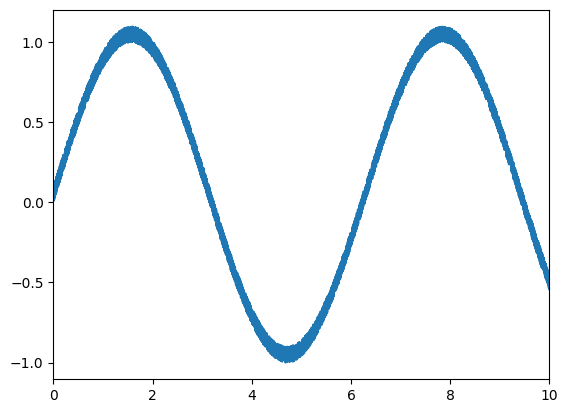

In [38]:
t = np.arange(100000)*0.001
data = np.sin(t)+np.random.uniform(0,0.1, size= 100000)
plt.plot(t,data)
plt.xlim(0,10)

[ 0.    0.01  0.02 ... -0.03 -0.02 -0.01]


(0.0, 10.0)

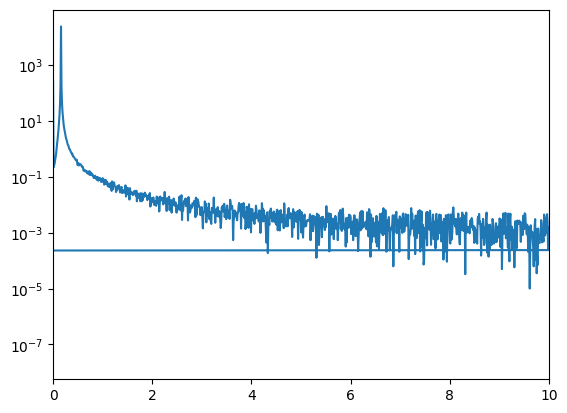

In [20]:
freqs = np.fft.fftfreq(100000,0.001)
print(freqs)
spectral_density = np.abs(np.fft.fft(data, norm='ortho'))**2
plt.semilogy(freqs, spectral_density)
plt.xlim(0,10)


In [21]:
peaks = find_peaks(spectral_density,threshold=0.01, distance=10)[0]
1/freqs[peaks]

array([ 6.25      ,  2.56410256,  1.96078431,  1.36986301,  1.14942529,
        1.        ,  0.84033613,  0.7518797 ,  0.68493151,  0.5952381 ,
        0.55555556,  0.44444444,  0.36630037,  0.30864198, -0.30864198,
       -0.36630037, -0.44444444, -0.55555556, -0.5952381 , -0.68493151,
       -0.7518797 , -0.84033613, -1.        , -1.14942529, -1.36986301,
       -1.96078431, -2.56410256, -6.25      ])